## Rede de ruas do OpenStreetMap com OSMnx e Python #2
### Analisando a tabela de atributos com Numpy, Pandas, Matplotlib e Seaborn

#### Para o blog [paulovitorweb.wordpress.com](https://paulovitorweb.wordpress.com/)

Seguindo com nossas postagens sobre a análise de rede de ruas do OpenStreetMap com a biblioteca OSMnx para Python, vamos ver quais dados estão disponíveis além da geometria. Primeiro, importamos as bibliotecas que vamos usar:

In [1]:
import osmnx as ox
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Em seguida, vamos definir a área que queremos importar, neste caso a partir de uma string que representa o bairro do Centro de João Pessoa.

In [2]:
place = "Centro, João Pessoa, Brazil"

Usamos a função graph_from_place para importar a rede de ruas públicas dirigíveis (`network_type=”drive”`).

In [3]:
graph = ox.graph_from_place(place, network_type='drive')

Fazemos o plot através da função `plot_graph`, que, como retorna uma tupla com dois valores (figura e eixo, objetos do matplotlib), já podemos desestruturá-la armazenando nas variáveis fig e ax. No Jupyter, a execução dessa linha de código já exibe o plot.

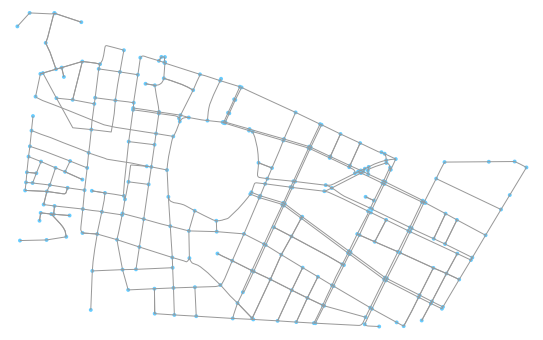

In [4]:
fig, ax = ox.plot_graph(graph)

Vamos dar uma olhada nos campos associados a cada segmento de rua. Para isso, usamos a função `graph_to_gdfs` para converter nossa rede (sem os nós) para um objeto DataFrame do geopandas. Fazemos isso para termos acesso a métodos específicos de um objeto DataFrame.

In [5]:
edg = ox.graph_to_gdfs(graph, nodes=False, edges=True)

Através do método `info`, temos algumas informações, como quantidade de registros (519), quantidade de colunas (13), o nome de cada uma, a quantidade de registros não nulos e o tipo da coluna (campo).

In [6]:
edg.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 519 entries, 0 to 518
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   u         519 non-null    int64   
 1   v         519 non-null    int64   
 2   key       519 non-null    int64   
 3   osmid     519 non-null    object  
 4   oneway    519 non-null    bool    
 5   name      510 non-null    object  
 6   highway   519 non-null    object  
 7   length    519 non-null    float64 
 8   geometry  519 non-null    geometry
 9   maxspeed  48 non-null     object  
 10  lanes     6 non-null      object  
 11  tunnel    2 non-null      object  
 12  bridge    1 non-null      object  
dtypes: bool(1), float64(1), geometry(1), int64(3), object(7)
memory usage: 49.3+ KB


[Aqui](https://wiki.openstreetmap.org/wiki/Map_Features) você encontra uma descrição detalhada de cada campo.

Vamos ver os detalhes de alguns campos. Um método especialmente útil pra isso é o `value_counts`, disponível por coluna – observe que cada coluna de um objeto DataFrame é um outro objeto chamado Series, do pandas, e é este objeto que possui o método `value_counts`. Vamos ver com detalhes o campo oneway, que informa se a via é de mão única ou dupla:

In [7]:
edg['oneway'].value_counts()

True     365
False    154
Name: oneway, dtype: int64

Usando o parâmetro `normalize=True` temos como retorno a frequência relativa. Sabemos, portanto, que 70% dos segmentos de rua da nossa área de estudo são de mão única – segundo, claro, a base do OpenStreetMap.

In [8]:
edg['oneway'].value_counts(normalize=True)

True     0.703276
False    0.296724
Name: oneway, dtype: float64

Outro campo interessante é o `highway`, que traz a classificação na hierarquia viária.

In [9]:
edg['highway'].value_counts()

residential     197
primary         191
tertiary        100
secondary        28
primary_link      3
Name: highway, dtype: int64

Normalizando os dados temos a frequência relativa. Vias residenciais, primárias e terciárias se destacam na nossa rede.

In [10]:
edg['highway'].value_counts(normalize=True)

residential     0.379576
primary         0.368015
tertiary        0.192678
secondary       0.053950
primary_link    0.005780
Name: highway, dtype: float64

Podemos visualizar num gráfico de barras usando o `countplot` do Seaborn, uma biblioteca Python de visualização de dados, passando nosso DataFrame e definindo o campo highway como eixo X.

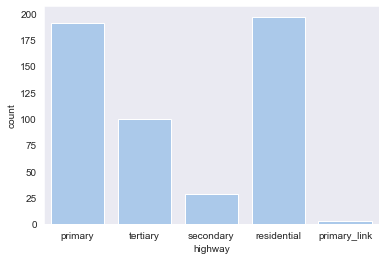

In [11]:
sns.set_style('dark')
sns.set_color_codes('pastel')
sns.countplot(x='highway', data=edg, color='b')

Vamos dar uma olhada nos nomes dos logradouros.

In [12]:
edg['name']

0        Avenida Duarte da Silveira
1      Avenida Maximiano Figueiredo
2      Avenida Maximiano Figueiredo
3              Avenida Dom Pedro II
4               Avenida João Amorim
                   ...             
514    Avenida Maximiano Figueiredo
515             Avenida Dom Pedro I
516                             NaN
517            Avenida João Machado
518            Avenida Dom Pedro II
Name: name, Length: 519, dtype: object

Se usarmos o `value_counts()`, o Python vai nos avisar que há listas neste campo, mas vai conseguir calcular o que queremos. Ocorre que o campo name, além de strings, também pode conter valores nulos e listas, que é quando um segmento faz parte de mais de um logradouro.

Podemos ver quando isso ocorre, percorrendo nossos registros e verificando quando o valor é uma instância do objeto `list`.

In [13]:
for n in edg['name']:
    if isinstance(n, list):
        print(n)

['Avenida Duque de Caxias', 'Rua Peregrino de Carvalho']
['Rua da Areia', 'Rua Peregrino de Carvalho']
['Avenida Presidente Getúlio Vargas', 'Parque Sólon de Lucena']
['Avenida Almirante Barroso', 'Parque Solon de Lucena']
['Avenida João Machado', 'Avenida Maximiano Figueiredo']
['Praça Pedro Américo', 'Praça Aristides Lobo']
['Rua Guedes Pereira', 'Rua Padre Meira', 'Túnel Damásio Franca']
['Avenida Presidente Getúlio Vargas', 'Parque Sólon de Lucena']
['Rua Rodrigues de Aquino', 'Rua Padre Meira']
['Avenida Visconde de Pelotas', 'Praça Dom Adauto']
['Rua Cardoso Vieira', 'Via Expressa Miguel Couto']
['Praça Dom Ulrico', 'Rua Vigário Sarlen']


Pode ser interessante sabermos a extensão total da nossa rede. Podemos obter somando todas as extensões da seguinte forma:

In [14]:
edg['length'].sum()

42971.801999999996

Sabemos, portanto, que nossa rede tem cerca de 43 quilômetros de extensão.

Também podemos descobrir a extensão média: 82,8 metros.

In [15]:
edg['length'].mean()

82.79730635838149

Podemos ver a distribuição desses valores num histograma:

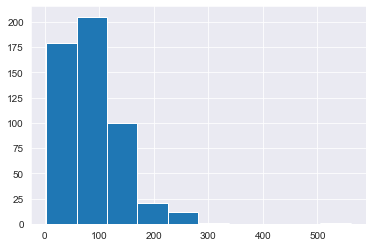

In [16]:
edg['length'].hist()

Podemos ver o histograma separado por vias de mão única e dupla. Neste caso, vamos aplicar o método `hist` para o DataFrame inteiro. Usamos o parâmetro `bins` para definir as classes do histograma, para serem as mesmas para ambos os gráficos. Se não fizermos isso, pode ficar difícil fazer a comparação. Interessante observar que as distribuições são parecidas; apenas o conjunto das vias de mão única tem uma cauda ligeiramente mais longa à direita.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002569A5624C8>,
      dtype=object)

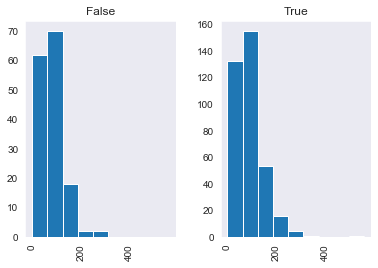

In [17]:
bins = np.linspace(0, edg['length'].max(), 10)
edg.hist(column='length', by='oneway', bins=bins)

Com isso, já temos um norte para calcular outras medidas, fazer outras agregações e gerar outros gráficos. Aconselho a dar uma olhada na documentação das bibliotecas que usamos aqui.

Na próxima postagem da série vamos trabalhar com uma funcionalidade muito útil para a área de morfologia urbana.